In [1]:
import numpy as np
import scipy.linalg as la
from matplotlib import pyplot as plt
from scipy import sparse as sp
from time import time
import scipy.sparse.linalg as spla
from math import sqrt
import simulated_data as simd
import data_strm_subclass as dssb
import streaming_subclass as stsb
import plot_functions as pf
import pickle


In [4]:
def expvar(X, W, xnorm2=None):
    '''
    Calculate the explained variance of X
    Inputs:
        X: n x d array-like
        W: d x k array-like
        xnorm2: optional float, the squared frobenius norm of X. This is often
            calculated in other applications and can thus be provided.
    '''
    
    if xnorm2 is None:
        xnorm2 = la.norm(X, ord='fro')**2
    return la.norm(X.dot(W), ord='fro')**2 / xnorm2

# Synthetic Data

# Small Bag of Words Data

In [11]:
# Load Small bag of words data
kos_n, kos_d, kos_nnz, kos_dense, kos_SpX, kos_norm2 = dssb.get_bagX('docword.kos.txt') 
nips_n, nips_d, nips_nnz, nips_dense, nips_SpX, nips_norm2 = dssb.get_bagX('docword.nips.txt')
#enr_n, enr_d, enr_nnz, enr_dense, enr_SpX, enr_norm2 = dssb.get_bagX('docword.enron.txt')

In [15]:
k = 1
B = 10

In [16]:
# Obtain true ExpVar for Small Bag-of-words data
v_kos = spla.svds((kos_SpX.T.dot(kos_SpX)).astype(float), k=k)[2].T
kos_expvar = la.norm(kos_SpX.dot(v_kos), ord='fro')**2 / kos_norm2

v_nips = spla.svds((nips_SpX.T.dot(nips_SpX)).astype(float), k=k)[2].T
nips_expvar = la.norm(nips_SpX.dot(v_nips), ord='fro')**2 / nips_norm2

#v_enr = spla.svds((enr_SpX.T.dot(enr_SpX)).astype(float), k=k)[2].T
#enr_expvar = la.norm(enr_SpX.dot(v_enr), ord='fro')**2 / enr_norm2

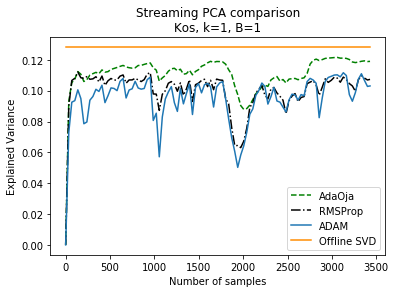

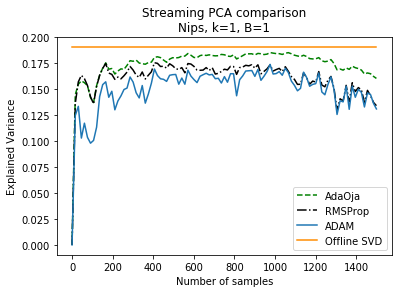

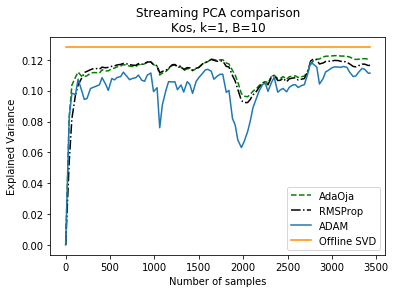

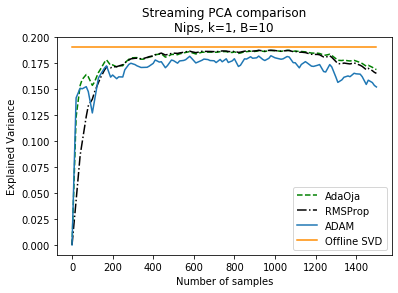

Number of accuracy readings is greater than the number of samples. Setting num_acc to int(n/B)
Number of accuracy readings is greater than the number of samples. Setting num_acc to int(n/B)
Number of accuracy readings is greater than the number of samples. Setting num_acc to int(n/B)
Number of accuracy readings is greater than the number of samples. Setting num_acc to int(n/B)
Number of accuracy readings is greater than the number of samples. Setting num_acc to int(n/B)
Number of accuracy readings is greater than the number of samples. Setting num_acc to int(n/B)


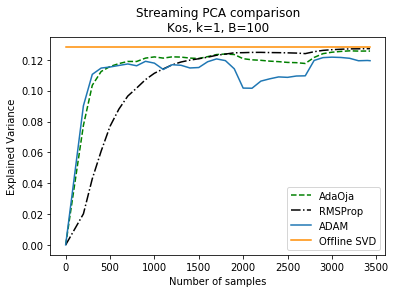

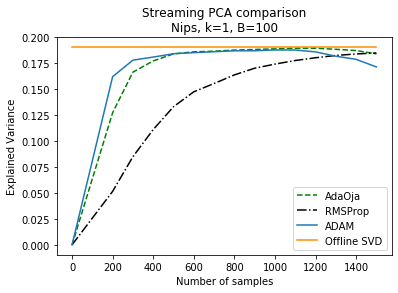

In [17]:
# Plot comparison of AdaOja, RMSProp and ADAM convergence (varying B)
for B in [1, 10, 100]:
    adaoja_kos, rmsp_kos, adam_kos = dssb.run_sim_bag('docword.kos.txt', k, methods=['AdaOja','RMSProp', 'ADAM'], eta=.1, B=B, X=kos_SpX, xnorm2=kos_norm2, b0_dim=1)
    adaoja_nips, rmsp_nips, adam_nips = dssb.run_sim_bag('docword.nips.txt', k, methods=['AdaOja','RMSProp', 'ADAM'], B=B, X=nips_SpX, xnorm2=nips_norm2, eta=.1, b0_dim=1)
    #adaoja_enr, rmsp_enr, adam_enr = dssb.run_sim_bag('docword.enron.txt', k, methods=['AdaOja','RMSProp', 'ADAM'], B=B, X=enr_SpX, xnorm2=enr_norm2, eta=.1, b0_dim=1)
    pf.plot_mom_comp(adaoja_kos, rmsp_kos, adam_kos, 'Kos', true_evar=kos_expvar)
    pf.plot_mom_comp(adaoja_nips, rmsp_nips, adam_nips, 'Nips', true_evar=nips_expvar)
    #pf.plot_mom_comp(adaoja_enr, rmsp_enr, adam_enr, 'Enron', true_evar=enr_expvar)

# CIFAR

In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Load the CIFAR data
db = []
for i in range(1, 6):
    db.append(unpickle('data_batch_' + str(i))[b'data'])
CIFAR = np.vstack(db)

# Centralize the CIFAR data
CIFAR_sc = CIFAR - CIFAR.mean(axis=0)
CIFAR_norm2 = la.norm(CIFAR_sc, ord='fro')**2
v_CIFAR = la.eigh(np.cov(CIFAR.T))[1][:,::-1]

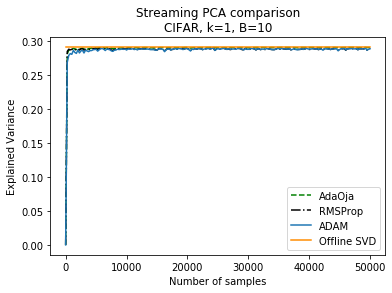

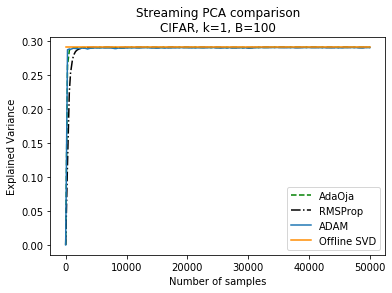

In [6]:
# Plot comparison of AdaOja, HPCA and SPM convergence for B=10, 100; k=1...10
k=1
for B in [10, 100]:
    ada_CIFAR, rmsp_CIFAR, adam_CIFAR = dssb.run_sim_fullX(CIFAR_sc, k, methods=['AdaOja','RMSProp', 'ADAM'], B=B, Sparse=False, xnorm2 = CIFAR_norm2, num_acc=200, bias_correction=False, b0_dim=1, eta=.1)
    CIFAR_evar = expvar(CIFAR_sc, v_CIFAR[:,:k], xnorm2=CIFAR_norm2)
    pf.plot_mom_comp(ada_CIFAR, rmsp_CIFAR, adam_CIFAR, 'CIFAR', true_evar=CIFAR_evar)

# ADAM and RMSProp

## Recommended parameters and bias correction

## Single Value, Vector and Matrix cases

## The effect of block size, B